In [1]:
import numpy as np
from scipy.special import erf
from scipy.stats import beta as beta_dist
from scipy.stats import truncnorm
from scipy.interpolate import interp1d
import bilby
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from bilby.core.prior import Uniform
from bilby.core.sampler import run_sampler
from bilby.core.prior import LogUniform
from bilby.hyper.likelihood import HyperparameterLikelihood
from scipy import interpolate
from scipy import integrate
import random
import argparse
import os
import sys
import glob
import warnings
warnings.filterwarnings("ignore")

10:50 bilby INFO    : Running for label 'u_hype_17373', output will be saved to 'hy_outdir'
10:50 bilby INFO    : Search parameters:
10:50 bilby INFO    :   alpha = Uniform(minimum=-5, maximum=25, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
10:50 bilby INFO    :   mmin = Uniform(minimum=0.9, maximum=2.9, name='mmin', latex_label='$mmin$', unit=None, boundary=None)
10:50 bilby INFO    :   mmax = Uniform(minimum=1.9, maximum=2.9, name='mmax', latex_label='$mmax$', unit=None, boundary=None)
10:50 bilby INFO    :   delta_m = Uniform(minimum=0.01, maximum=1, name='delta', latex_label='$\\delta$', unit=None, boundary=None)
10:50 bilby INFO    : Single likelihood evaluation took 2.090e-02 s


0it [00:00, ?it/s]

10:50 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 400, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 8, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 240, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f2d916c5370>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
10:50 bilby INFO    : Checkpoint every check_point_delta_t = 600s
10:50 bilby INFO    : Using dynesty version 1.1
10:50 bilby INFO    : Using the bilby-implemented rwalk sample

11:39 bilby INFO    : Sampling time: 0:48:01.213885
11:40 bilby INFO    : Summary of results:
nsamples: 3745
ln_noise_evidence:  0.000
ln_evidence: 53.795 +/-  0.143
ln_bayes_factor: 53.795 +/-  0.143



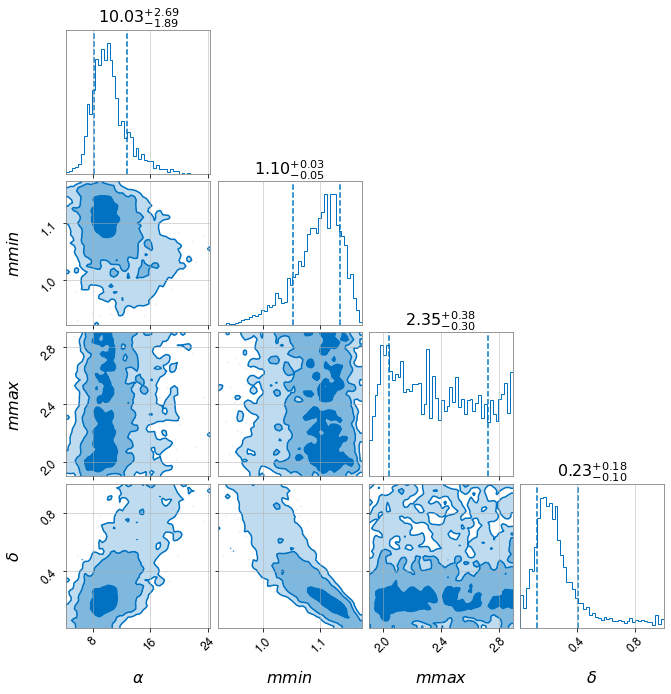

In [3]:
# set paramaters
outdir='hy_outdir'
data_exp=np.loadtxt('cal_li.txt')
npool=8
NN=48
nlive=400
mx=5000

# load data
data_df=list()
ns_m=data_exp
for i in range(NN):
    re=pd.DataFrame(ns_m[i*5000:(i+1)*5000],columns=['mu'])
    data_df.append(re)
samples = data_df

#turn_on_pow
def hyper_prior_turn_on_pow(dataset, alpha, mmin, mmax, delta_m):
    parameters = dict(
        alpha=alpha, mmin=mmin, mmax=mmax, delta_m=delta_m)
    pow_norm = norm_ppow(parameters)
    probability = turn_on_pow(dataset['mu'], parameters, pow_norm)
    return probability

def turn_on_pow(ms, parameters, pow_norm):
    al, mn, mx, delta_m = extract_mass_parameters(parameters)
    p_pow = ppow(ms, parameters) / pow_norm
    return  p_pow 

def ppow(ms, parameters):
    """1d unnormalised powerlaw mass probability with smoothed low-mass end"""
    al, mn, mx, delta_m = extract_mass_parameters(parameters)
    return ms**(-al) * window(ms, mn, mx, delta_m)

def norm_ppow(parameters):
    """normalise ppow, requires m1s, an array of m values, and dm, the spacing of
    that array"""
    return np.trapz(ppow(m1s, parameters), m1s)

def window(ms, mn, mx, delta_m):
    """Apply a one sided window between mmin and mmin+dm to the mass pdf.

    The upper cut off is a step function,
    the lower cutoff is a logistic rise over delta_m solar masses.

    See T&T18 Eq

    """
    dM = mx - mn
    delta_m /= dM
    # some versions of numpy can't deal with pandas columns indexing an array
    ms_arr = np.array(ms)
    sel_p = (ms_arr >= mn) & (ms_arr <= (mn + delta_m * dM))
    ms_p = ms_arr[sel_p] - mn
    Zp = np.nan_to_num(2 * delta_m * (1 / (2 * ms_p / dM) +
                       1 / (2 * ms_p / dM - 2 * delta_m)))
    window = np.ones_like(ms)
    window[(ms_arr < mn) | (ms_arr > mx)] = 0
    window[sel_p] = 1 / (np.exp(Zp) + 1)
    return window

def extract_mass_parameters(parameters):
    """extract the parameters of the mass distribution hyperparameters used in
    T&T18 from either a list or dictionary."""
    if isinstance(parameters, list):
        return parameters
    elif isinstance(parameters, dict):
        keys = ['alpha', 'mmin', 'mmax', 'delta_m']
        return [parameters[key] for key in keys]

# set up arrays for numerical normalisation
m1s = np.linspace(0.9, 2.9, 100)
dm = m1s[1] - m1s[0]

hp_priors_turn_on_pow= dict(alpha=Uniform(-5, 25, 'alpha', '$\\alpha$'),
                 mmin=Uniform(0.9, 2.9, 'mmin', '$mmin$'),
                mmax=Uniform(1.9, 2.9, 'mmax', '$mmax$'),
                delta_m=Uniform(0.01, 1, 'delta', '$\\delta$'))

# useing hyper PE
def run_prior(dataset):
    return 1/(2.9-0.9)

hp_likelihood = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_turn_on_pow,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors=hp_priors_turn_on_pow

# And run sampler
result = run_sampler(
    likelihood=hp_likelihood, priors=hp_priors, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result.plot_corner()